In [1]:
from os import path
import numpy as np
import pandas as pd
import natsort
import glob
import cv2
import os
import tifffile as tiff
import imageio
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
import scipy.io
from skimage.transform import warp
from skimage.draw import polygon
from PIL import Image
import tifffile as tiff
import seaborn as sns
import dask.array as da
import imageio
import imagecodecs
import math
import skimage
import os
from skimage import transform
import scanpy as sc
from scipy.sparse import issparse
from scipy.stats import linregress
from sklearn.metrics import roc_curve, auc

In [3]:
stitched_image = np.load('stitched_images_BFP/stitched_BFP.npy')


# Transform Cell Boundary

In [4]:
csv_file_path = 'path/to/file/cell_boundaries.csv.gz'
cell_boundaries_csv = pd.read_csv(csv_file_path)

cell_boundaries_csv['vertex_x_coord'] = cell_boundaries_csv['vertex_x']/0.2125
cell_boundaries_csv['vertex_y_coord'] = cell_boundaries_csv['vertex_y']/0.2125

affine_matrix = np.loadtxt('path/to/file/matrix.csv', delimiter=',')
affine_matrix_inv = np.linalg.inv(affine_matrix)

In [12]:
homogeneous_coordinates = np.hstack([cell_boundaries_csv[['vertex_x_coord', 'vertex_y_coord']].values, 
                                     np.ones((cell_boundaries_csv.shape[0], 1))])
transformed_coordinates = homogeneous_coordinates.dot(affine_matrix_inv.T)
cell_boundaries_csv['x_transformed'] = transformed_coordinates[:, 0]
cell_boundaries_csv['y_transformed'] = transformed_coordinates[:, 1]

cell_boundaries_csv['x_transformed'] = round(cell_boundaries_csv['x_transformed']).astype(int)
cell_boundaries_csv['y_transformed'] = round(cell_boundaries_csv['y_transformed']).astype(int)

cell_boundaries_csv['x_transformed'] = cell_boundaries_csv['x_transformed'].clip(lower=0, upper=stitched_image.shape[1]-1)
cell_boundaries_csv['y_transformed'] = cell_boundaries_csv['y_transformed'].clip(lower=0, upper=stitched_image.shape[0]-1)


# Calculate mean intensity

In [18]:
cell_ids = []
mean_intensities = []
for cell_id, group in cell_boundaries_csv.groupby('cell_id'):
    cell_ids.append(cell_id)
    x_coords = group['x_transformed'].values
    y_coords = group['y_transformed'].values

    rr, cc = polygon(y_coords, x_coords, stitched_image.shape)
    mean_intensity = stitched_image[rr, cc].mean()

    mean_intensities.append(mean_intensity)

/tmp/ipykernel_202232/4247082326.py:9: RuntimeWarning: Mean of empty slice.
  mean_intensity = stitched_image[rr, cc].mean()
/home/mingjiay/miniconda3/envs/scanpy0923/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
#np.save('mean_intensities_perturbation_BFP.npy', mean_intensities)
#np.save("cell_ids_0421_perturbation_BFP.npy", cell_ids)

In [23]:
mean_intensities_log = np.log1p(mean_intensities)

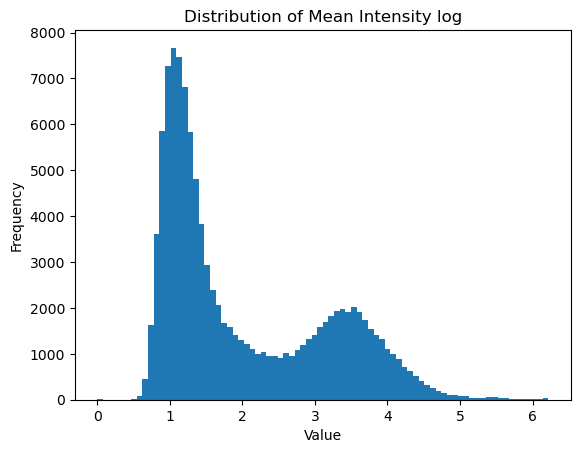

In [24]:
plt.hist(mean_intensities_log, bins=80)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Intensity log")
plt.show()

# Check gRNA cells

In [132]:
adata_xenium = sc.read_10x_h5(
    filename="path/to/file/cell_feature_matrix.h5"
)


In [133]:
adata_xenium

AnnData object with n_obs × n_vars = 118403 × 480
    var: 'gene_ids', 'feature_types', 'genome'

In [136]:
adata_filtered = adata_xenium[adata_xenium.obs['total_counts'] >= 800].copy()

In [137]:
adata_filtered

AnnData object with n_obs × n_vars = 70514 × 480
    obs: 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome'

In [138]:
sgRNA_genes = [gene for gene in adata_filtered.var_names if '-' in gene and not 'HLA' in gene]
sgRNA_to_target = {sg: sg.split('-')[0] for sg in sgRNA_genes}

In [139]:
idxs = [adata_filtered.var_names.get_loc(g) for g in sgRNA_genes]
mat = adata_filtered.X[:, idxs]
if issparse(mat):
    mat = mat.toarray()
bin_mat = (mat > 0).astype(int)
df_ind = pd.DataFrame(
    bin_mat,
    index=adata_filtered.obs_names,
    columns=[g for g in sgRNA_genes]
)
adata_filtered.obs = adata_filtered.obs.join(df_ind)

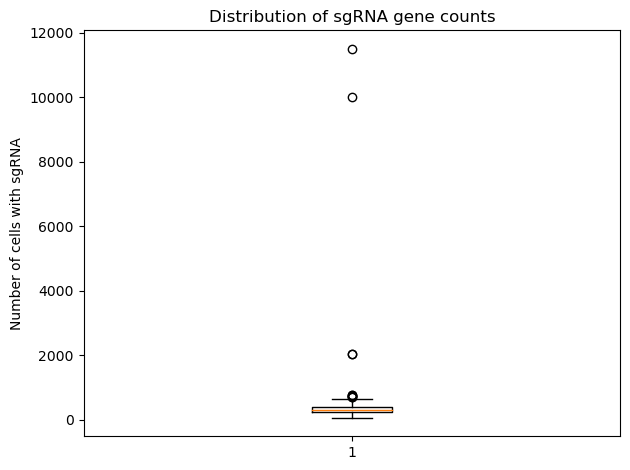

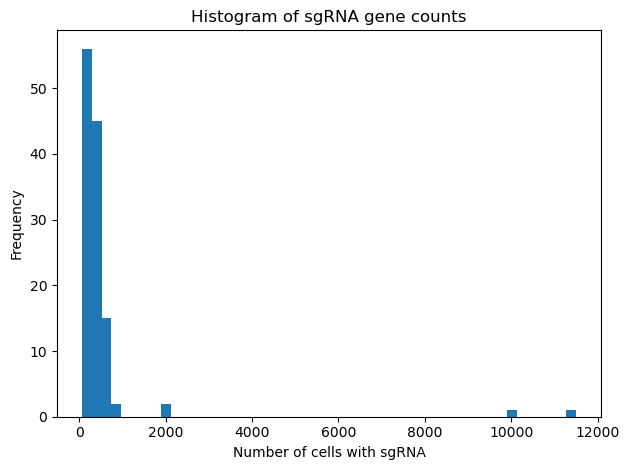

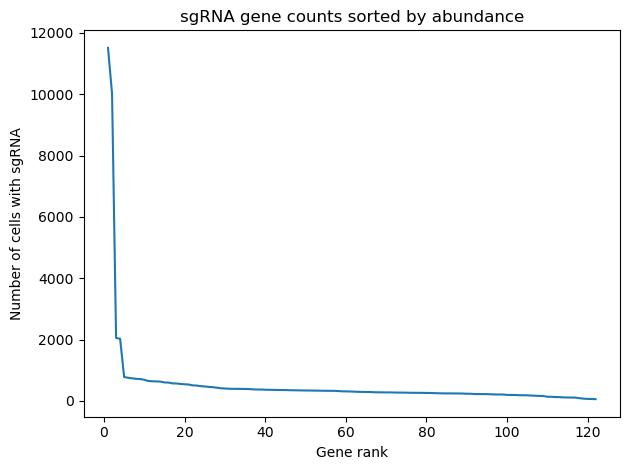

In [141]:
obs_clean = adata_filtered.obs.drop(columns=["total_counts"], errors="ignore")
gene_cols = [g for g in sgRNA_genes if g in obs_clean.columns]

counts = obs_clean[gene_cols].sum(axis=0).sort_values(ascending=False)
counts_df = pd.DataFrame({
    "gene":  counts.index,
    "count": counts.values
})
counts_df["rank"] = counts_df["count"].rank(ascending=False, method="dense")

# --- Plot A: Boxplot of counts ---
plt.figure()
plt.boxplot(counts_df["count"])
plt.ylabel("Number of cells with sgRNA")
plt.title("Distribution of sgRNA gene counts")
plt.tight_layout()
plt.show()

# --- Plot B: Histogram of counts ---
plt.figure()
plt.hist(counts_df["count"], bins=50)
plt.xlabel("Number of cells with sgRNA")
plt.ylabel("Frequency")
plt.title("Histogram of sgRNA gene counts")
plt.tight_layout()
plt.show()

# --- Plot C: Sorted counts scatter ---
plt.figure()
plt.plot(range(1, len(counts_df)+1), counts_df["count"])
plt.xlabel("Gene rank")
plt.ylabel("Number of cells with sgRNA")
plt.title("sgRNA gene counts sorted by abundance")
plt.tight_layout()
plt.show()

In [142]:
print(counts_df.head(10))

        gene  count  rank
0      ID2-4  11508   1.0
1     SOX5-3  10011   2.0
2     NFIB-2   2052   3.0
3      ID2-2   2026   4.0
4    CREB5-3    777   5.0
5  ONECUT2-5    755   6.0
6  ONECUT1-5    736   7.0
7    RUNX1-1    720   8.0
8     SIX1-1    713   9.0
9    CREB5-2    689  10.0


In [143]:
top4 = counts_df.loc[:3, 'gene'].tolist()
remaining = [
    col for col in adata_filtered.obs.columns
    if col not in top4 + ['total_counts']
]
adata_filtered.obs['sgRNA_Gene_count'] = (
    adata_filtered.obs[remaining].sum(axis=1)
)
adata_filtered.obs['perturbation'] = np.where(
    adata_filtered.obs['sgRNA_Gene_count'] > 0,
    'perturbed',
    'unperturbed'
)


In [146]:
df = adata_filtered.obs.copy()
intensity = pd.Series(mean_intensities, index=cell_ids, name='mean_intensity')
valid = df.index.intersection(intensity.index)

df2 = df.loc[valid, ['sgRNA_Gene_count', 'perturbation']].copy()
df2['mean_intensity'] = intensity.loc[valid]
df2['log1p_intensity'] = np.log1p(df2['mean_intensity'])

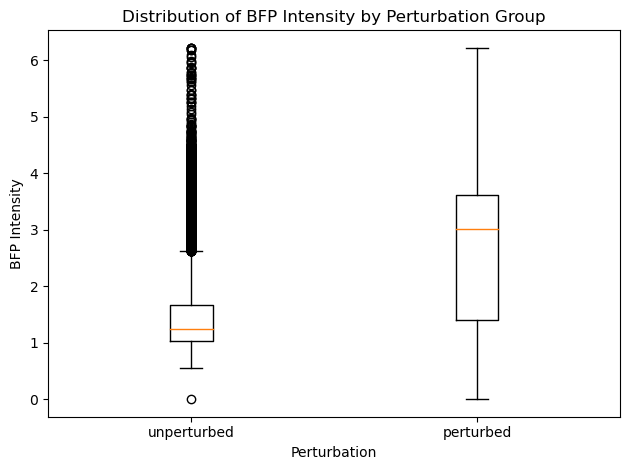

In [148]:
clean = df2[['perturbation', 'log1p_intensity']].dropna()
group_unperturbed = clean.loc[clean['perturbation'] == 'unperturbed', 'log1p_intensity']
group_perturbed   = clean.loc[clean['perturbation'] == 'perturbed',   'log1p_intensity']

plt.figure()
plt.boxplot([group_unperturbed, group_perturbed], labels=['unperturbed', 'perturbed'])
plt.xlabel('Perturbation')
plt.ylabel('BFP Intensity')
plt.title('Distribution of BFP Intensity by Perturbation Group')
plt.tight_layout()
plt.show()


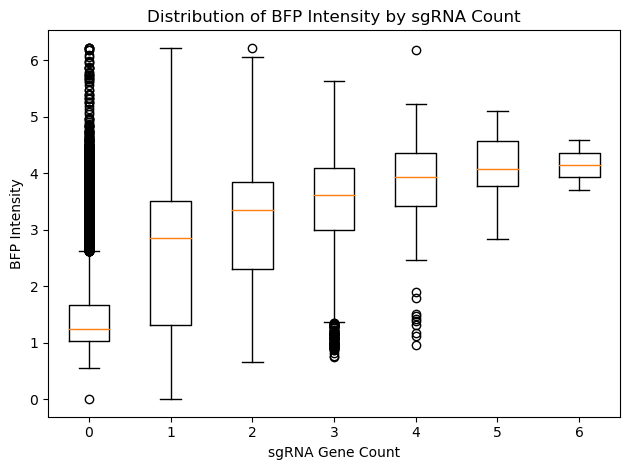

In [149]:
clean = df2[['sgRNA_Gene_count', 'log1p_intensity']].dropna()
groups = [
    clean.loc[clean['sgRNA_Gene_count'] == i, 'log1p_intensity']
    for i in sorted(clean['sgRNA_Gene_count'].unique())
]
labels = sorted(clean['sgRNA_Gene_count'].unique())

plt.figure()
plt.boxplot(groups, labels=labels)
plt.xlabel('sgRNA Gene Count')
plt.ylabel('BFP Intensity')
plt.title('Distribution of BFP Intensity by sgRNA Count')
plt.tight_layout()
plt.show()


# Threshold for BFP+ and BFP- cells

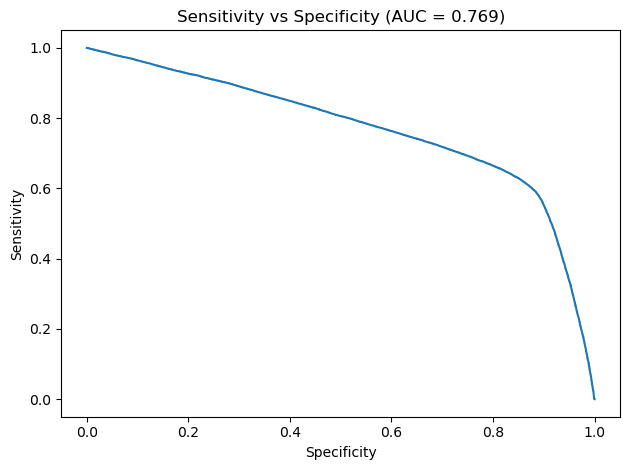

Best threshold: 2.290
Sensitivity: 0.622
Specificity: 0.857


In [151]:
clean = df2[['perturbation', 'log1p_intensity']].dropna()
y_true = (clean['perturbation'] == 'perturbed').astype(int).values
scores = clean['log1p_intensity'].values

fpr, tpr, thresholds = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)
specificity = 1 - fpr

plt.figure()
plt.plot(specificity, tpr)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title(f'Sensitivity vs Specificity (AUC = {roc_auc:.3f})')
plt.tight_layout()
plt.show()

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
best_sensitivity = tpr[best_idx]
best_specificity = specificity[best_idx]

print(f'Best threshold: {best_threshold:.3f}')
print(f'Sensitivity: {best_sensitivity:.3f}')
print(f'Specificity: {best_specificity:.3f}')


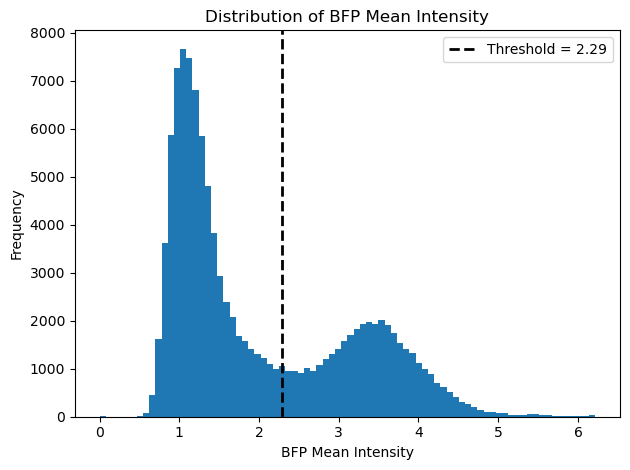

In [62]:
plt.hist(mean_intensities_log, bins=80)
plt.axvline(
    x=2.29,
    color='black',
    linestyle='--',
    linewidth=2,
    label='Threshold = 2.29'
)
plt.xlabel("BFP Mean Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of BFP Mean Intensity")
plt.legend()
plt.tight_layout()
plt.show()